# 0. Preliminaries

1. Import plot decision boundary (for later usage). This imports the source file from the repo to the current directory.

In [144]:
import requests
from pathlib import Path

FILE = "helper_functions.py"
URL = f"https://raw.githubusercontent.com/mpiza/pytorch-deep-learning.main/{FILE}"
# Download helper function from Learn PyTorch repo (if not already present)
if Path(FILE).is_file():
    print(f"{FILE} already present")
else:
    print(f"Downloading {FILE} from repo")
    url = URL
    request = requests.get(url)
    print(request.status_code)
    if (request.status_code != 200):
        print(f"Failed to download {FILE} from  repo")
        exit()
    else:
         with open(FILE, 'wb') as f:
           f.write(request.content)

helper_functions.py already present


In [145]:
from helper_functions import plot_decision_boundary

# Steps 

1. Make data 



# 1. Data

## 1.1. Make data and labels

In [146]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles


X, y = make_circles(n_samples=1000, noise=0.3, factor=0.1, random_state=0)

# data shape and type
print(X.shape, y.shape)
print(type(X), type(y))

(1000, 2) (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# 1.2. Convert data to tensors

In [147]:
import torch

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# data shape and type
print(X.shape, y.shape)
print(type(X), type(y))



torch.Size([1000, 2]) torch.Size([1000])
<class 'torch.Tensor'> <class 'torch.Tensor'>


## 1.3. Split data  into train and test

In [148]:
from  sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print a few samples and labels
n_samples = 5
print(X_train[:n_samples], y_train[:n_samples])


torch.Size([800, 2]) torch.Size([800])
torch.Size([200, 2]) torch.Size([200])
tensor([[ 0.1157,  0.0507],
        [ 0.1582,  0.3784],
        [ 0.7576,  0.5600],
        [ 0.8702, -0.8347],
        [-0.7279, -0.7392]]) tensor([1., 1., 0., 0., 0.])


# 2. Model

## 2.1 NN model

In [149]:
from torch import nn

class model0(nn.Module):
    def __init__(self, input_size, hidden_sizes,output_size):
        super(model0, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc3 (self.relu (self.fc2 (self.relu (self.fc1(x)) ) ) )
        return x

In [150]:
class model1(nn.Module):
    def __init__(self, input_size, hidden_sizes,output_size):
        super(model1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1],hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc4(self.relu (self.fc3 (self.relu (self.fc2 (self.relu (self.fc1(x)) ) ) )))
        return x

In [151]:
# Device independent code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [152]:
input_size = 2
hidden_sizes1 = [5,5,5]
hidden_sizes0 = [5,5]
output_size = 1

model =  model1(input_size, hidden_sizes1,output_size).to(device)
model = model0(input_size, hidden_sizes0,output_size).to(device)

print(model)


model0(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


# 3. Optimizer and loss function

In [153]:
loss_fun = nn.BCEWithLogitsLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

# Note: optimizer knows model parameters. It is the one that updates them. Parameters have the grad attribute
# that is updated by the backward() method of the loss function. The optimizer uses the grad attribute to update
# the parameters. The grad attribute is set to zero by the zero_grad() method of the optimizer. This is done
# before the backward() method of the loss function is called.  


In [154]:
# Accuraccy function. Takes the prediction and the labels and returns the accuracy
def accuracy_fun(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

# 4. Model training

## 4.1 Training loop

In [155]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Loop over epochs
n_epochs = 30000

for epoch in range(n_epochs):
    
    # Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
     
    if epoch == 0:
        print(y_logits.shape, y_pred.shape, y_train.shape) # check shapes

    # Compute Loss
    loss = loss_fun(y_logits, y_train)

    # Zero out gradients
    optimizer.zero_grad() # same as model.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    # Testing
    model.eval()

    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))
        loss_test = loss_fun(y_logits_test, y_test)
        loss_acc = accuracy_fun(y_test, y_pred_test)



    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.3f}, loss_test: {loss_test:.3f}, acc: {loss_acc:.3f}')

torch.Size([800]) torch.Size([800]) torch.Size([800])
Epoch: 0, loss: 0.712, loss_test: 0.732, acc: 46.000


Epoch: 1000, loss: 0.233, loss_test: 0.201, acc: 91.500
Epoch: 2000, loss: 0.230, loss_test: 0.204, acc: 92.500
Epoch: 3000, loss: 0.230, loss_test: 0.204, acc: 92.500
Epoch: 4000, loss: 0.230, loss_test: 0.204, acc: 92.500
Epoch: 5000, loss: 0.230, loss_test: 0.204, acc: 92.500
Epoch: 6000, loss: 0.229, loss_test: 0.204, acc: 92.500
Epoch: 7000, loss: 0.229, loss_test: 0.204, acc: 92.500
Epoch: 8000, loss: 0.229, loss_test: 0.206, acc: 92.000
Epoch: 9000, loss: 0.228, loss_test: 0.207, acc: 91.500
Epoch: 10000, loss: 0.228, loss_test: 0.207, acc: 91.500
Epoch: 11000, loss: 0.228, loss_test: 0.208, acc: 92.000
Epoch: 12000, loss: 0.228, loss_test: 0.208, acc: 91.500
Epoch: 13000, loss: 0.228, loss_test: 0.208, acc: 92.000
Epoch: 14000, loss: 0.228, loss_test: 0.208, acc: 91.500
Epoch: 15000, loss: 0.227, loss_test: 0.207, acc: 91.500
Epoch: 16000, loss: 0.226, loss_test: 0.207, acc: 91.500
Epoch: 17000, loss: 0.226, loss_test: 0.207, acc: 91.000
Epoch: 18000, loss: 0.225, loss_test: 0.

# 5. Make predictions

In [156]:
model.eval()
with torch.inference_mode():
    y_logits_test = model(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    loss_test = loss_fun(y_logits_test, y_test)
    loss_acc = accuracy_fun(y_test, y_pred_test)


print(y_pred_test[:10], y_test[:10])
print(f'loss_test: {loss_test:.3f}, acc: {loss_acc:.3f}')

tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0') tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0')
loss_test: 0.213, acc: 93.500


# 6. Plot decision boundary

Text(0.5, 1.0, 'Test')

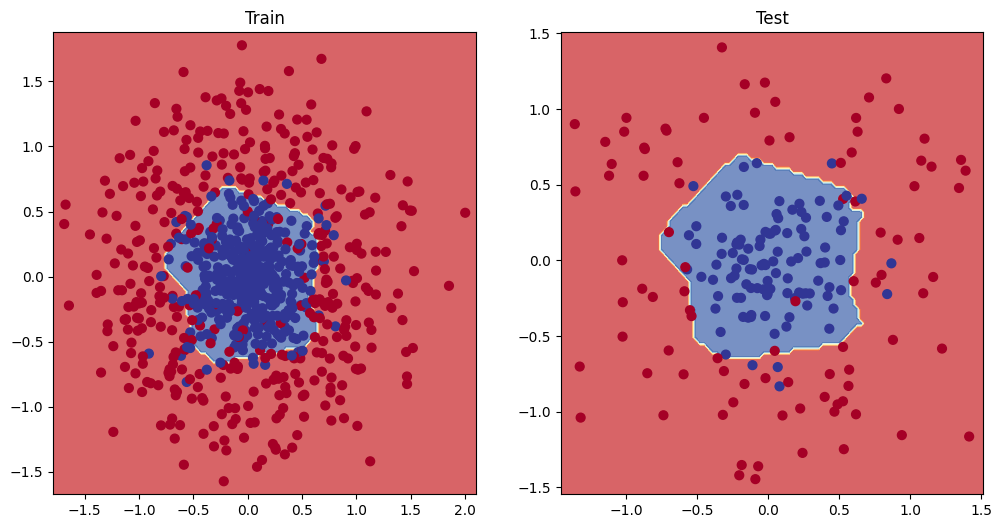

In [157]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model, X_train, y_train)
plt.title('Train')
plt.subplot(1, 2, 2)
plot_decision_boundary(model, X_test, y_test)
plt.title('Test')